In [1]:
from keras.datasets import cifar10
from keras.models import model_from_json
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt

from keras import backend as K

Using TensorFlow backend.


In [2]:
batch_size = 32
epochs = 5

In [3]:
eps = 0.01
loop = 2
max_n = 100

In [4]:
num_classes = 10

In [5]:
def predict(x, model):
    pred = model.predict(np.array([x]), batch_size=1)
    pred_class = np.argmax(pred)
    pred_per = max(pred[0])
    
    return pred_class, pred_per

In [6]:
def generate_p(x, label, model):
    class_output = model.output[:, int(label)]
    
    grads = K.gradients(class_output, model.input)[0]
    gradient_function = K.function([model.input], [grads])

    grads_val = gradient_function([np.array([x])])
    
    p = np.sign(grads_val)
    
    return p.reshape(32,32,3)

In [7]:
def generate_adv(x, label, model, eps):
    p = generate_p(x, label, model)
    adv = (x - eps*p).clip(min=0, max=1)
    
    return adv

In [8]:
def generate_adv_list(x_list, y_list, model, eps):
    adv_list = []
    
    for x, y in zip(x_list, y_list):
        adv = generate_adv(x, y, model, eps)
        adv_list.append(adv)
        
    return np.array(adv_list)

In [9]:
# データの読み込み
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 正規化
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

y_train_catego = to_categorical(y_train, num_classes)
y_test_catego = to_categorical(y_test, num_classes)

In [10]:
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

50000 train samples
10000 test samples


In [11]:
# モデルを読み込む
model = model_from_json(open('models/10_model.json').read())

# 学習結果を読み込む
model.load_weights('weights/10_weights.h5')

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

print(model.summary())

W0109 09:26:58.692564 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0109 09:26:58.712997 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0109 09:26:58.746907 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0109 09:26:58.749985 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0109 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [12]:
score = model.evaluate(x_test, y_test_catego, verbose=0)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

Test loss : 0.6479467062950134
Test accuracy : 0.7745


In [13]:
label =['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'boat', 'track']

In [14]:
adv_test = []
for i in range(loop):
    advs = generate_adv_list(x_test[i*max_n:(i+1)*max_n], y_test[i*max_n:(i+1)*max_n], model, eps)
    adv_test.extend(advs)
    print(i)

adv_test = np.array(adv_test)
adv_test.shape

0
1


(200, 32, 32, 3)

In [15]:
score = model.evaluate(adv_test, y_test_catego[:loop*max_n], verbose=0)
print('adv')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

adv
Test loss : 2.1086998844146727
Test accuracy : 0.375


In [16]:
score = model.evaluate(x_test[:loop*max_n], y_test_catego[:loop*max_n], verbose=0)
print('x')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

x
Test loss : 0.6276324093341827
Test accuracy : 0.795


adv
p: pred_class, t: true_class


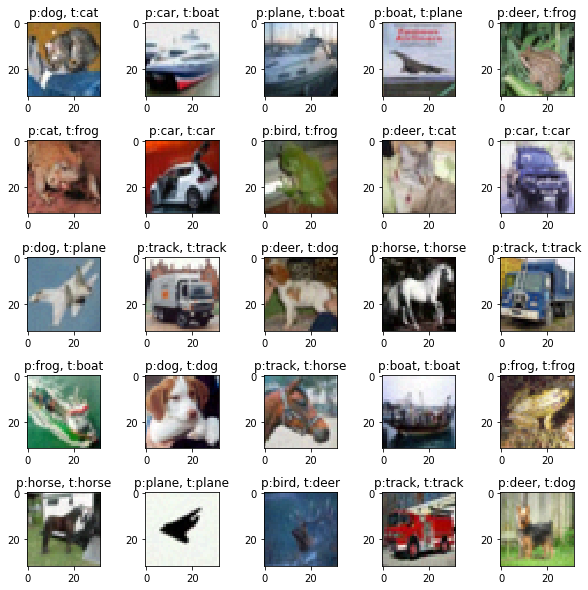

In [17]:
print('adv')
print('p: pred_class, t: true_class')
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(25):
    cifar_img=plt.subplot(5,5,i+1)
    
    img = adv_test[i]
    pred_class, pred_per = predict(img, model)
    plt.imshow(img)
    plt.title('p:{0}, t:{1}'.format(label[pred_class],label[int(y_test[i])]))

plt.show()

x
p: pred_class, t: true_class


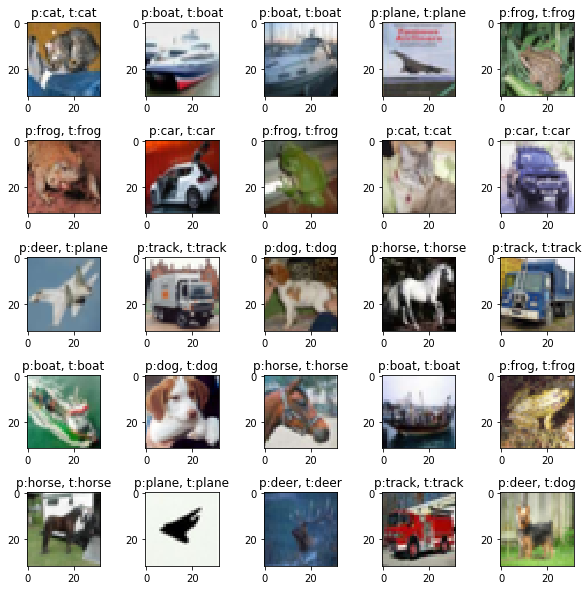

In [18]:
print('x')
print('p: pred_class, t: true_class')
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(25):
    cifar_img=plt.subplot(5,5,i+1)
    
    img = x_test[i]
    pred_class, pred_per = predict(img, model)
    plt.imshow(img)
    plt.title('p:{0}, t:{1}'.format(label[pred_class],label[int(y_test[i])]))

plt.show()

In [19]:
adv_train = []
for i in range(loop):
    advs = generate_adv_list(x_train[i*max_n:(i+1)*max_n], y_train[i*max_n:(i+1)*max_n], model, eps)
    adv_train.extend(advs)
    print(i)

adv_train = np.array(adv_train)
adv_train.shape

0
1


(200, 32, 32, 3)

In [20]:
history = model.fit(adv_train, y_train_catego[:loop*max_n],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test_catego))
score = model.evaluate(x_test, y_test_catego, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model_json_str = model.to_json()
open('models/200advs_model.json', 'w').write(model_json_str)
model.save_weights('weights/200advs_weights.h5');
print('model saved.')

W0109 09:39:48.931116 140736235160512 deprecation.py:323] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 200 samples, validate on 10000 samples
Epoch 1/5
200/200 [==============================] - 17s 85ms/step - loss: 1.7210 - acc: 0.4500 - val_loss: 0.8844 - val_acc: 0.6945
Epoch 2/5
200/200 [==============================] - 8s 40ms/step - loss: 1.2773 - acc: 0.5650 - val_loss: 0.7723 - val_acc: 0.7427
Epoch 3/5
200/200 [==============================] - 8s 40ms/step - loss: 0.9475 - acc: 0.6200 - val_loss: 0.8117 - val_acc: 0.7192
Epoch 4/5
200/200 [==============================] - 9s 45ms/step - loss: 0.7620 - acc: 0.7150 - val_loss: 0.8478 - val_acc: 0.7071
Epoch 5/5
200/200 [==============================] - 8s 39ms/step - loss: 0.6417 - acc: 0.7600 - val_loss: 0.8369 - val_acc: 0.7054
Test loss: 0.8369354494094848
Test accuracy: 0.7054
model saved.


In [21]:
score = model.evaluate(x_test, y_test_catego, verbose=0)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

Test loss : 0.8369354494094848
Test accuracy : 0.7054


In [22]:
score = model.evaluate(x_test[:loop*max_n], y_test_catego[:loop*max_n], verbose=0)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

Test loss : 0.8143331265449524
Test accuracy : 0.71


In [23]:
score = model.evaluate(adv_test, y_test_catego[:loop*max_n], verbose=0)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

Test loss : 1.4627928256988525
Test accuracy : 0.47


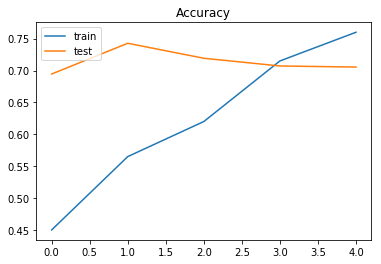

In [25]:
# 正解率の推移をプロット
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
# plt.show()
plt.savefig("graphs/200adv_acc.png")

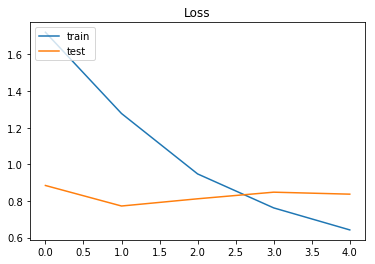

In [26]:
plt.cla()

# ロスの推移をプロット
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
# plt.show()
plt.savefig("graphs/200adv_loss.png")